# Policy Gradients Implementation


- Set Up Hyperparameters and environment.
- Build a MLP model for policy learning.
- Initialize the agent, such as define the policy network and optimizer.
- Forward Computation: Sample trajectories by conducting an action given an observation from the environment, and calculate sum of rewards in each trajectory, That includes `sample_action`, `sample_trajectory`, `sample_trajectories` and `sum_of_rewards`.
- Backward Computation: Optimize the policy network based on the update rule. That contains `compute_advantage`, `estimate_return`, `get_log_prob` , `update_parameters`.


In [1]:
!pip install gym==0.10.5

In [2]:
# Install gym-snake
!pip install -e ./Gym-Snake-master/

Obtaining file:///G:/Git/NUS_MComp/CS5446/cs5446_grp_proj/Gym-Snake-master
  Attempting uninstall: gym-snake
    Found existing installation: gym-snake 0.0.1
    Uninstalling gym-snake-0.0.1:
      Successfully uninstalled gym-snake-0.0.1
  Running setup.py develop for gym-snake


In [3]:
import numpy as np
import math
import gym
import gym_snake
import os
import time
import inspect
import sys
from multiprocessing import Process
import torch
from torch import nn as nn
import torch.nn.functional as F
import snakeUtils

## Set Up Hyperparameters

In [4]:
env_name = 'snake-v0'
render = False
animate = render
discount = 1.0
n_iter = 1001
batch_size = 1000
ep_len = -1.
learning_rate = 1e-3
reward_to_go = False
dont_normalize_advantages = False
seed = 1
n_experiments = 1
max_path_length = 1e3
min_timesteps_per_batch = batch_size
gamma = discount
normalize_advantages = not(dont_normalize_advantages)

## Lr Schedule

In [5]:
# 0.003 ~ 0.0004
def lrs(current_iter):
    low = math.log2(1e-4)
    high = math.log2(5e-3)
    return 2**(high-(high-low)*current_iter/n_iter)

In [6]:
lrs(100)

0.0033825383656066366

## Set Up Environment

In [7]:
#========================================================================================#
# Set Up Env
#========================================================================================#

# Make the gym environment
env = gym.make(env_name)

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Is this env continuous, or self.discrete? In this assignment, we only consider discrete action space.
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Observation and action sizes
ob_dim = 5
ac_dim = env.action_space.n if discrete else env.action_space.shape[0]
print(ac_dim)

4


G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
env.reset()
env.controller.snakes[0].head
# snakeUtils.get_food_pos(env.controller.grid.grid)

array([7, 4])

## Build a MLP model for policy learning.

In [9]:
class MLP(nn.Module):

    def __init__(self, input_size, num_actions):
        super(MLP, self).__init__()
        self.dense1 = nn.Linear(input_size, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, num_actions)

    def forward(self, x):
        x = F.tanh(self.dense1(x))
        x = F.tanh(self.dense2(x))
        out = F.softmax(self.dense3(x))
        return out


## Initialize Agent
    

In [10]:
policy_net = MLP(input_size=ob_dim, num_actions=ac_dim)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)


## Data Sampling

In [11]:
def sample_action(policy_parameters):
    """
    Stochastically sampling from the policy distribution

    arguments:
        policy_parameters: logits of a categorical distribution over actions
                sy_logits_na: (batch_size, self.ac_dim)

    returns:
        sy_sampled_ac: (batch_size,)
    """
    
    sy_sampled_ac = torch.multinomial(policy_parameters, 1)

    return sy_sampled_ac

In [12]:
sample_input = torch.Tensor([[0.4,0.6, 1.5], [1.0, 4.0, 3.0]])
sampled_acs = sample_action(sample_input)
print(sampled_acs)

tensor([[0],
        [2]])


In [13]:
print(ob_dim)
print(ac_dim)

5
4


In [14]:
def sample_trajectory(env):
    ob = env.reset()
    obs, acs, rewards = [], [], []
    steps = 0
    
    snake_position = env.controller.snakes[0].head
    snake_direction = env.controller.snakes[0].direction
    # ignore snake body for now
    # snake_body = env.controller.snakes[0].body
    food_position = snakeUtils.get_food_pos(env.controller.grid.grid)
    state = np.concatenate((snake_position, [snake_direction], food_position))
    #print(state)
    while True:

        obs.append(state)

        state = torch.Tensor(state)
        
        distribution = policy_net(torch.unsqueeze(state, 0))
        ac = sample_action(distribution)

        ac = ac.numpy()[0]
        acs.append(ac)
        ob, rew, done, _ = env.step(ac)
        rewards.append(rew)
        
        steps += 1
        if done or steps > max_path_length or env.controller.snakes[0] == None:
            break
        else:
            snake_position = env.controller.snakes[0].head
            snake_direction = env.controller.snakes[0].direction
            # ignore snake body for now
            # snake_body = env.controller.snakes[0].body
            food_position = snakeUtils.get_food_pos(env.controller.grid.grid)
            state = np.concatenate((snake_position, [snake_direction], food_position))
    path = {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32)}
    return path, steps


In [15]:
def sample_trajectories(itr, env):
    """Collect paths until we have enough timesteps, as determined by the
    length of all paths collected in this batch.
    """
    timesteps_this_batch = 0
    paths = []
    steps_list = []
    while True:
        path, steps= sample_trajectory(env)
        paths.append(path)
        steps_list.append(steps)
        timesteps_this_batch += len(path["reward"])
        if timesteps_this_batch > min_timesteps_per_batch:
            break
    return paths, timesteps_this_batch, steps_list

In [16]:
sample_trajectories(1, env)

G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


([{'observation': array([[ 7.,  4.,  2., 12.,  8.],
          [ 6.,  4.,  3., 12.,  8.],
          [ 5.,  4.,  3., 12.,  8.],
          [ 5.,  5.,  2., 12.,  8.],
          [ 6.,  5.,  1., 12.,  8.],
          [ 6.,  4.,  0., 12.,  8.],
          [ 5.,  4.,  3., 12.,  8.],
          [ 5.,  5.,  2., 12.,  8.],
          [ 6.,  5.,  1., 12.,  8.],
          [ 6.,  4.,  0., 12.,  8.],
          [ 6.,  3.,  0., 12.,  8.],
          [ 6.,  2.,  0., 12.,  8.],
          [ 6.,  1.,  0., 12.,  8.],
          [ 6.,  0.,  0., 12.,  8.],
          [ 5.,  0.,  3., 12.,  8.]], dtype=float32),
   'reward': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0., -1.], dtype=float32),
   'action': array([[3.],
          [1.],
          [2.],
          [1.],
          [0.],
          [3.],
          [2.],
          [1.],
          [0.],
          [2.],
          [0.],
          [0.],
          [0.],
          [3.],
          [0.]], dtype=float32)},
  {'observation': array

For sum of rewards, we use the total discounted reward summed over entire trajectory (regardless of which time step the Q-value should be for).

In [17]:
def sum_of_rewards(re_n):
    """ Monte Carlo estimation of the Q function.

    let sum_of_path_lengths be the sum of the lengths of the paths sampled from
        the function sample_trajectories
    let num_paths be the number of paths sampled from sample_trajectories

    arguments:
        re_n: length: num_paths. Each element in re_n is a numpy array
            containing the rewards for the particular path

    returns:
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths

    """

    q_n = np.zeros(len(re_n))
    for i in range(len(re_n)):
        for j in range(len(re_n[i])):
            q_n[i] += pow(gamma, j) * re_n[i][j]

    return q_n

In [18]:
test_array = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]
result = sum_of_rewards(test_array)
print(result)

[11.  5.  7.]


## Apply Policy Gradient

We firstly need to estimate return `estimate_return` and calculate log probability of actions `get_log_prob`. Then we can update parameters based on the rule:

\begin{equation}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t=1}^T \gamma^{t-1} r(s_{it},a_{it}) \right)
\end{equation}

In [19]:
def compute_advantage(ob_no, q_n):
  
    adv_n = q_n.copy()
    return adv_n

In [20]:
def estimate_return(ob_no, re_n):
    """ Estimates the returns over a set of trajectories.

    let sum_of_path_lengths be the sum of the lengths of the paths sampled from
        sample_trajectories
    let num_paths be the number of paths sampled from sample_trajectories

    arguments:
        ob_no: shape: (sum_of_path_lengths, ob_dim)
        re_n: length: num_paths. Each element in re_n is a numpy array
            containing the rewards for the particular path

    returns:
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
        adv_n: shape: (sum_of_path_lengths). A single vector for the estimated
            advantages whose length is the sum of the lengths of the paths
    """
    #print("rewards from paths")
    #print(re_n)
    q_n = sum_of_rewards(re_n)
    adv_n = compute_advantage(ob_no, q_n)

    if normalize_advantages:

        mean = adv_n.mean()
        std = adv_n.std()
        if std < 1e-6:
            std = 1e-6
        adv_n = (adv_n - mean) / std

    return q_n, adv_n

In [21]:
test_array2 = torch.Tensor([1, 2, 3, 4, 5])
test_array3 = torch.Tensor([5, 4, 3, 2, 1])
result2a, result2b = estimate_return(test_array, test_array)
print(result2b.mean())
print(result2b.std())
print(result2b)

-1.4802973661668753e-16
1.0
[ 1.33630621 -1.06904497 -0.26726124]


In [22]:
def get_log_prob(policy_parameters, sy_ac_na):
    """
    Compute the log probability of a set of actions that were actually taken according to the policy

    arguments:
        policy_parameters: logits of a categorical distribution over actions
                sy_logits_na: (batch_size, self.ac_dim)

        sy_ac_na: (batch_size,)

    returns:
        sy_logprob_n: (batch_size)

    """

    sy_logits_na = policy_parameters


    sy_ac_na = np.array(sy_ac_na).astype(int)
    #print(sy_ac_na)
    sy_logprob_n = torch.zeros(len(sy_ac_na))
    #print(sy_ac_na)
    for j in range(len(sy_ac_na)):
        sy_logprob_n[j] = torch.log(sy_logits_na[j][sy_ac_na[j]])

    return sy_logprob_n

In [23]:
policy_parameters = torch.Tensor([[0.2, 0.8], [0.4, 0.6], [0.5, 0.5], [0.9, 0.1]])
sy_ac_na = [0, 1, 0, 1]
get_log_prob(policy_parameters, sy_ac_na)

tensor([-1.6094, -0.5108, -0.6931, -2.3026])

In [24]:
def update_parameters(ob_no, ac_na, q_n, adv_n, steps_list, current_iter):
    """
    Update the parameters of the policy and (possibly) the neural network baseline,
    which is trained to approximate the value function.

    arguments:
        ob_no: shape: (sum_of_path_lengths, ob_dim)
        ac_na: shape: (sum_of_path_lengths).
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
        adv_n: shape: (sum_of_path_lengths). A single vector for the estimated
            advantages whose length is the sum of the lengths of the paths

    returns:
        nothing
    """
    
    lr = lrs(current_iter)
    optimizer = torch.optim.Adam(policy_net.parameters(),lr=lr)
    optimizer.zero_grad()

    ob_no = torch.Tensor(ob_no)
    ob_no.requires_grad_()

    log_prob = get_log_prob(policy_net(ob_no), ac_na)
    # log_prob.requires_grad_()
    adv_n = torch.Tensor(adv_n)
    q_n = np.array(q_n).astype(int)

    traj_log_prob_sum = torch.zeros(len(q_n))
    k = 0
    for i in range(len(steps_list)):
        for j in range(steps_list[i]):
            traj_log_prob_sum[i] += log_prob[k]
            k += 1

    loss = - torch.sum(torch.mul(traj_log_prob_sum, adv_n)) / len(adv_n)    #noted here we are minimizing what? Maximizing is equivalent to what?

    #print(q_n)
    #print(loss)
    loss.backward()   #to compute gradient with pytorch tensor

    optimizer.step() #update according to gradient and optimizer


## Training Loop.

In [25]:
print('Running experiment with seed %d'%seed)

start = time.time()

total_timesteps = 0

return_data = []

for itr in range(n_iter):

    paths, timesteps_this_batch, steps_list = sample_trajectories(itr, env)
    total_timesteps += timesteps_this_batch

    # Build arrays for observation, action for the policy gradient update by
    # concatenating across paths
    ob_no = np.concatenate([path["observation"] for path in paths])
    ac_na = np.concatenate([path["action"] for path in paths])
    steps_list = np.array(steps_list, dtype=int)
#     print(ob_no.shape)
#     print(ac_na.shape)
#     print(steps_list.sum())

    re_n = [path["reward"] for path in paths]

    q_n, adv_n = estimate_return(ob_no, re_n)


    update_parameters(ob_no, ac_na, q_n, adv_n, steps_list, itr)

    # Log diagnostics
    returns = [path["reward"].sum() for path in paths]

    if itr%10 == 0:
        print("********** Iteration %i ************"%itr)
        ep_lengths = [len(path["reward"]) for path in paths]
        print("Time: ", time.time() - start)
        print("Iteration: ", itr)
        print("AverageReturn: ", np.mean(returns))
        print("StdReturn: ", np.std(returns))
        print("MaxReturn: ", np.max(returns))
        print("MinReturn", np.min(returns))
        print("EpLenMean: ", np.mean(ep_lengths))
        print("EpLenStd: ", np.std(ep_lengths))
        print("TimestepsThisBatch: ", timesteps_this_batch)
        print("TimestepsSoFar: ", total_timesteps)
    return_data.append(np.mean(returns))

Running experiment with seed 1


G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


********** Iteration 0 ************
Time:  0.7669870853424072
Iteration:  0
AverageReturn:  -0.8888889
StdReturn:  0.3928371
MaxReturn:  1.0
MinReturn -1.0
EpLenMean:  28.833333333333332
EpLenStd:  21.98673842721259
TimestepsThisBatch:  1038
TimestepsSoFar:  1038
********** Iteration 10 ************
Time:  7.960571050643921
Iteration:  10
AverageReturn:  -0.95238096
StdReturn:  0.21295887
MaxReturn:  0.0
MinReturn -1.0
EpLenMean:  23.976190476190474
EpLenStd:  16.27807186317736
TimestepsThisBatch:  1007
TimestepsSoFar:  11148
********** Iteration 20 ************
Time:  15.22547698020935
Iteration:  20
AverageReturn:  -0.8181818
StdReturn:  0.5195887
MaxReturn:  1.0
MinReturn -1.0
EpLenMean:  30.484848484848484
EpLenStd:  24.25261149589839
TimestepsThisBatch:  1006
TimestepsSoFar:  21344
********** Iteration 30 ************
Time:  22.46464228630066
Iteration:  30
AverageReturn:  -0.62068963
StdReturn:  0.66507936
MaxReturn:  2.0
MinReturn -1.0
EpLenMean:  34.96551724137931
EpLenStd:  28

********** Iteration 310 ************
Time:  228.43626999855042
Iteration:  310
AverageReturn:  3.0
StdReturn:  2.529822
MaxReturn:  7.0
MinReturn -1.0
EpLenMean:  74.2
EpLenStd:  49.837335402286506
TimestepsThisBatch:  1113
TimestepsSoFar:  319564
********** Iteration 320 ************
Time:  235.95419025421143
Iteration:  320
AverageReturn:  1.8
StdReturn:  1.9131125
MaxReturn:  6.0
MinReturn -1.0
EpLenMean:  50.35
EpLenStd:  25.300741095865156
TimestepsThisBatch:  1007
TimestepsSoFar:  330082
********** Iteration 330 ************
Time:  243.32816219329834
Iteration:  330
AverageReturn:  1.0
StdReturn:  1.040833
MaxReturn:  3.0
MinReturn -1.0
EpLenMean:  42.0
EpLenStd:  26.83126286007922
TimestepsThisBatch:  1008
TimestepsSoFar:  340395
********** Iteration 340 ************
Time:  250.69152760505676
Iteration:  340
AverageReturn:  2.4210527
StdReturn:  2.9436069
MaxReturn:  9.0
MinReturn -1.0
EpLenMean:  54.421052631578945
EpLenStd:  38.91193267052056
TimestepsThisBatch:  1034
Timeste

********** Iteration 630 ************
Time:  468.52392578125
Iteration:  630
AverageReturn:  4.0
StdReturn:  2.9612887
MaxReturn:  10.0
MinReturn 0.0
EpLenMean:  81.76923076923077
EpLenStd:  55.87782530616905
TimestepsThisBatch:  1063
TimestepsSoFar:  652996
********** Iteration 640 ************
Time:  476.05310559272766
Iteration:  640
AverageReturn:  2.6
StdReturn:  1.8547237
MaxReturn:  7.0
MinReturn -1.0
EpLenMean:  67.8
EpLenStd:  31.26062486046411
TimestepsThisBatch:  1017
TimestepsSoFar:  663271
********** Iteration 650 ************
Time:  483.8192329406738
Iteration:  650
AverageReturn:  2.0526316
StdReturn:  2.2820508
MaxReturn:  7.0
MinReturn -1.0
EpLenMean:  58.0
EpLenStd:  41.3775937332984
TimestepsThisBatch:  1102
TimestepsSoFar:  673866
********** Iteration 660 ************
Time:  491.6260042190552
Iteration:  660
AverageReturn:  2.1176472
StdReturn:  2.3233433
MaxReturn:  9.0
MinReturn -1.0
EpLenMean:  61.1764705882353
EpLenStd:  34.632924311510024
TimestepsThisBatch:  1

********** Iteration 950 ************
Time:  713.6100769042969
Iteration:  950
AverageReturn:  5.0
StdReturn:  3.3763885
MaxReturn:  11.0
MinReturn 0.0
EpLenMean:  101.7
EpLenStd:  52.11343396860353
TimestepsThisBatch:  1017
TimestepsSoFar:  986634
********** Iteration 960 ************
Time:  721.2095839977264
Iteration:  960
AverageReturn:  3.3125
StdReturn:  1.8614091
MaxReturn:  7.0
MinReturn 0.0
EpLenMean:  65.8125
EpLenStd:  33.89914960216554
TimestepsThisBatch:  1053
TimestepsSoFar:  996949
********** Iteration 970 ************
Time:  729.0194728374481
Iteration:  970
AverageReturn:  4.75
StdReturn:  3.6314597
MaxReturn:  12.0
MinReturn -1.0
EpLenMean:  91.5
EpLenStd:  59.50700238907463
TimestepsThisBatch:  1098
TimestepsSoFar:  1007569
********** Iteration 980 ************
Time:  736.7318048477173
Iteration:  980
AverageReturn:  3.857143
StdReturn:  3.4404554
MaxReturn:  13.0
MinReturn -1.0
EpLenMean:  82.21428571428571
EpLenStd:  55.867417761580306
TimestepsThisBatch:  1151
Tim

## Plot Average-Return curve.





Text(0, 0.5, 'Average Return')

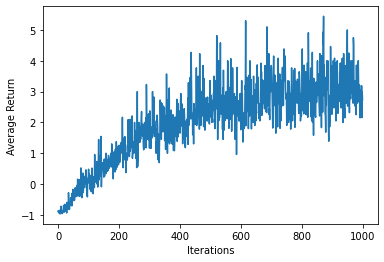

In [26]:
import matplotlib.pyplot as plt
plt.plot(return_data)
plt.xlabel("Iterations")
plt.ylabel("Average Return")